# 1. Settings

## 1.1 User variables

In [1]:
from config import *

NB_RUNS = 30

HEURISTICS = ["try_all_atoms", "max_coverage_static"] #["max_coverage_static"] #["try_all_atoms", "max_coverage_dynamic", "max_coverage_static", "max_diversity"]
USE_NAN = True

DATA_PATH = "tmp/data_discrete.csv"

# 1.2 Dev variables

In [2]:
RANDOM_SEED = 0

INPUT_DATA_DISCRETE = "tmp/data_discrete.csv"
OUTPUT_CSV = "tmp/lfit_output.csv"

VERBOSE = True

USE_GULA = True

## 1.3 Imports

In [3]:
import pandas as pd
import numpy
import random
import pylfit
import os

random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)

## 1.4 Constants

In [4]:
# Constants
DEBUG = False

# 2. Data Loading

# DEBUG

In [5]:
# DEBUG
print("Training dataset:")
df = pd.read_csv(DATA_PATH)
cols = [c for c in df.columns if c not in TARGETS]

#df = df.drop(columns=["Poaceae_prev"])

display(df)

Training dataset:


,M15,Picea,Pinus,Betula,Quercus,Ulmus,Ambrosia,Artemesia,Chenopodiaceae,Cyperaceae,Poaceae
0,0,1,0,0,1,1,0,1,1,0,1
1,1,0,1,1,0,0,1,0,0,1,0
2,0,1,1,0,0,1,1,0,0,1,0
3,0,0,0,1,1,0,0,1,1,1,0
4,1,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
56,1,0,1,0,0,0,0,0,1,1,0
57,0,1,0,1,1,0,1,1,0,1,0
58,1,1,0,1,0,1,0,0,0,0,1
59,0,0,1,1,0,0,1,1,1,0,1


In [6]:
# Load training dataset
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')

if not USE_NAN:
    df = df.dropna()
else:
    df = df.fillna("?")

col_order = list(df.columns)

df_output = pd.DataFrame(columns=["head_variable", "head_value", "nb_supports", "rule", "supports", "rule_str"])

if USE_GULA:
    df.to_csv("tmp/lfit_input.csv")

    # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
    dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
    model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
    model.compile(algorithm="gula") # model.compile(algorithm="pride")
    model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":1, "threads":THREADS, "supported_only":True})
    rules_supports = pylfit.postprocessing.influences.supports(model.rules,dataset)

    # Save rules
    rules_data = []

    for r in model.rules:
        rules_data.append([r.head.variable, r.head.value, len(rules_supports[r]), r, [(tuple(s1),tuple(s2)) for s1,s2 in rules_supports[r]], r.to_string()]) #, r.to_string()])

    df_output = pd.DataFrame(rules_data, columns=df_output.columns) #, "rule_raw_form"])

    nb_rules_of_run = len(df_output)
    
    print("rules found:", len(df_output))

    df_output.to_csv(OUTPUT_CSV,index=False)

else:

    FEATURES = [c for c in df.columns if c not in TARGETS]
    original_dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    for run_id in range(NB_RUNS):
        # Shuffle variables
        random.shuffle(col_order)
        df = df[col_order]

        FEATURES = [c for c in df.columns if c not in TARGETS]

        df.to_csv("tmp/lfit_input.csv")

        # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
        dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
        feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

        # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
        model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
        model.compile(algorithm="pride") # model.compile(algorithm="pride")
        model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":0, "threads":THREADS})
        rules_supports = pylfit.postprocessing.influences.supports(original_dataset)

        # Save rules
        rules_data = []

        for r in model.rules:
            rules_data.append([r.head.variable, r.head.value, len(rules_supports[r]), r, [(tuple(s1),tuple(s2)) for s1,s2 in rules_supports[r]], r.to_string()]) #, r.to_string()])

        df_rules = pd.DataFrame(rules_data, columns=df_output.columns) #, "rule_raw_form"])

        nb_rules_of_run = len(df_rules)
        nb_rules_total_before = len(df_output)

        df_output = pd.concat([df_output,df_rules]).reset_index(drop=True)
        df_output.drop_duplicates(subset=["rule_str"], inplace=True)

        nb_new_rules = len(df_output) - nb_rules_total_before
        nb_duplicate_rules = nb_rules_of_run - nb_new_rules
        
        print("Run",str(run_id+1)+"/"+str(NB_RUNS),"- new rules found:", nb_new_rules, "- total:",len(df_output),"- duplicate:",nb_duplicate_rules)

    df_output = df_output[["head_variable", "head_value", "nb_supports", "rule", "supports"]]
    df_output.to_csv(OUTPUT_CSV,index=False)

df_output = df_output.sort_values(["nb_supports"],ascending=False)

display(df_output[df_output["head_value"] == "0"])
display(df_output[df_output["head_value"] == "1"])

Starting fit with GULA

Converting transitions to nparray...
Sorting transitions...
Grouping transitions by initial state...
Start learning over 32 threads


rules found: 8349


,head_variable,head_value,nb_supports,rule,supports,rule_str
6049,Chenopodiaceae,0,33,Chenopodiaceae(0) :- Chenopodiaceae(0).,"[((1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0), (1, 0, 1,...",Chenopodiaceae(0) :- Chenopodiaceae(0).
5285,Artemesia,0,32,Artemesia(0) :- Artemesia(0).,"[((1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0), (1, 0, 1,...",Artemesia(0) :- Artemesia(0).
6815,Cyperaceae,0,32,Cyperaceae(0) :- Cyperaceae(0).,"[((0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1), (0, 1, 0,...",Cyperaceae(0) :- Cyperaceae(0).
2265,Betula,0,31,Betula(0) :- Betula(0).,"[((0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1), (0, 1, 0,...",Betula(0) :- Betula(0).
7595,Poaceae,0,31,Poaceae(0) :- Poaceae(0).,"[((1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0), (1, 0, 1,...",Poaceae(0) :- Poaceae(0).
...,...,...,...,...,...,...
1161,Picea,0,1,"Picea(0) :- Artemesia(0), Cyperaceae(0), M15(1...","[((1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0), (1, 0, 1,...","Picea(0) :- Artemesia(0), Cyperaceae(0), M15(1..."
1160,Picea,0,1,"Picea(0) :- Chenopodiaceae(0), Cyperaceae(0), ...","[((1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1), (1, 0, 1,...","Picea(0) :- Chenopodiaceae(0), Cyperaceae(0), ..."
1158,Picea,0,1,"Picea(0) :- Artemesia(0), M15(1), Pinus(1), Qu...","[((1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1), (1, 0, 1,...","Picea(0) :- Artemesia(0), M15(1), Pinus(1), Qu..."
1157,Picea,0,1,"Picea(0) :- Chenopodiaceae(1), M15(1), Pinus(1...","[((1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1), (1, 0, 1,...","Picea(0) :- Chenopodiaceae(1), M15(1), Pinus(1..."


,head_variable,head_value,nb_supports,rule,supports,rule_str
436,M15,1,34,M15(1) :- M15(1).,"[((1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0), (1, 0, 1,...",M15(1) :- M15(1).
4890,Ambrosia,1,32,Ambrosia(1) :- Ambrosia(1).,"[((1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0), (1, 0, 1,...",Ambrosia(1) :- Ambrosia(1).
1205,Picea,1,32,Picea(1) :- Picea(1).,"[((0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1), (0, 1, 0,...",Picea(1) :- Picea(1).
3318,Quercus,1,31,Quercus(1) :- Quercus(1).,"[((0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1), (0, 1, 0,...",Quercus(1) :- Quercus(1).
4110,Ulmus,1,30,Ulmus(1) :- Ulmus(1).,"[((0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1), (0, 1, 0,...",Ulmus(1) :- Ulmus(1).
...,...,...,...,...,...,...
4916,Ambrosia,1,1,"Ambrosia(1) :- Cyperaceae(0), M15(0), Picea(0)...","[((0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1), (0, 0, 0,...","Ambrosia(1) :- Cyperaceae(0), M15(0), Picea(0)..."
4917,Ambrosia,1,1,"Ambrosia(1) :- Cyperaceae(0), Picea(0), Pinus(...","[((0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1), (0, 0, 0,...","Ambrosia(1) :- Cyperaceae(0), Picea(0), Pinus(..."
4920,Ambrosia,1,1,"Ambrosia(1) :- Artemesia(1), Cyperaceae(0), Pi...","[((0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1), (0, 0, 0,...","Ambrosia(1) :- Artemesia(1), Cyperaceae(0), Pi..."
4922,Ambrosia,1,1,"Ambrosia(1) :- Artemesia(1), Cyperaceae(0), M1...","[((0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1), (0, 0, 1,...","Ambrosia(1) :- Artemesia(1), Cyperaceae(0), M1..."


# Influence Graph extraction

In [7]:
df_influences = pylfit.postprocessing.influences.extract_influences(model.rules,dataset)
df_influences

,target,feature,positive_influence,negative_influence,influence
0,M15,M15,58,0,58
1,Picea,Picea,58,0,58
9,Cyperaceae,Cyperaceae,58,0,58
8,Chenopodiaceae,Chenopodiaceae,58,0,58
7,Artemesia,Artemesia,58,0,58
...,...,...,...,...,...
2,Artemesia,Pinus,17,37,-20
2,Quercus,Pinus,18,39,-21
4,Pinus,Quercus,16,38,-22
3,Pinus,Betula,14,41,-27


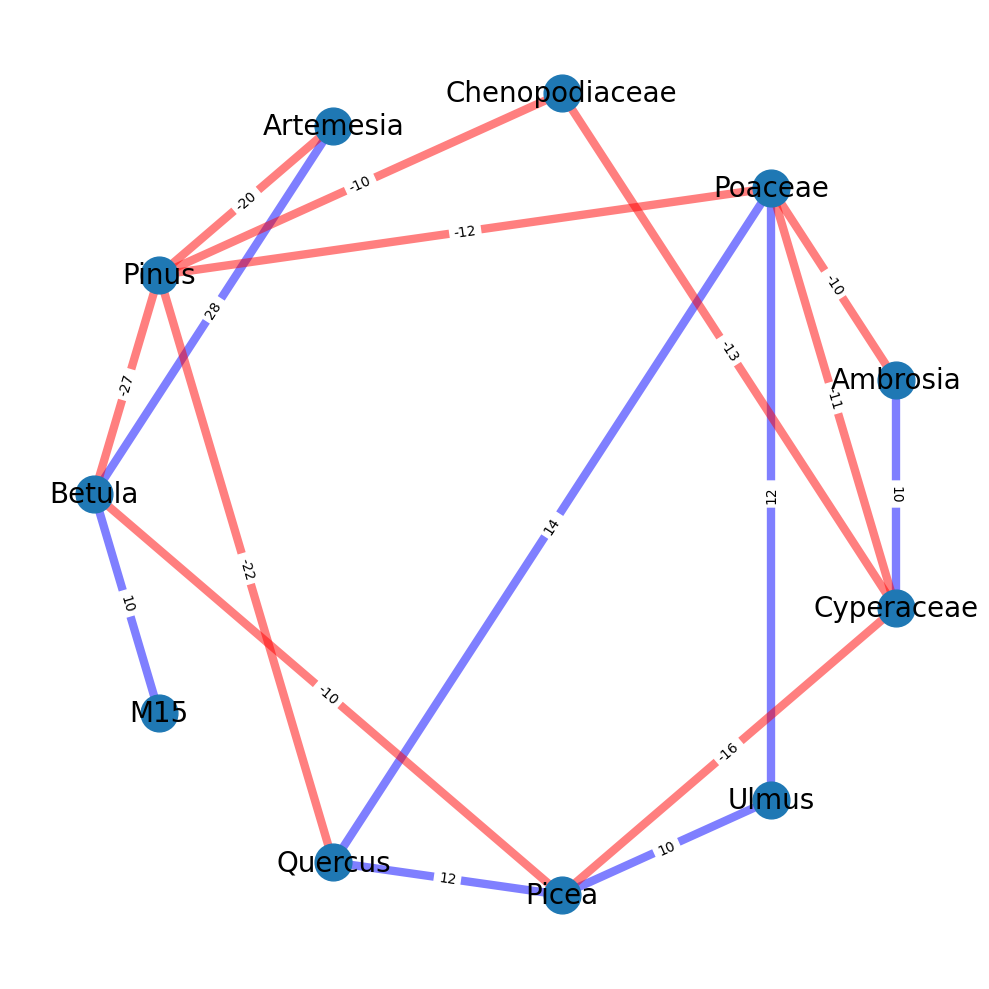

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

fig, ax = plt.subplots(figsize=(10,10))
G = nx.Graph()

MIN_INFLUENCE_SUPPORT = 10

for target in df_influences["target"].unique():
    df_tmp = df_influences[(df_influences["target"] == target) &
                           (df_influences["feature"] != target) &
                           (
                            (df_influences["influence"] >= MIN_INFLUENCE_SUPPORT) |
                            (df_influences["influence"] <= -MIN_INFLUENCE_SUPPORT)
                           )]

    #display(df_tmp)
    for idx, row in df_tmp.iterrows():
        G.add_edge(row["feature"], row["target"], weight=row["influence"])

positive_edge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= MIN_INFLUENCE_SUPPORT]
negative_edge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= -MIN_INFLUENCE_SUPPORT]

pos = nx.shell_layout(G)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700, ax=ax)

# edges
nx.draw_networkx_edges(G, pos, edgelist=positive_edge, width=6, alpha=0.5, edge_color="b", ax=ax)
nx.draw_networkx_edges(G, pos, edgelist=negative_edge, width=6, alpha=0.5, edge_color="r", ax=ax)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif", ax=ax)
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, ax=ax)

plt.axis("off")
plt.tight_layout()
plt.show()

# TODO